(**You can also open this notebook in Google Colab**)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/data-programming-with-python/blob/main/2023-fall/2023-11-14/notebook/code_demo.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Predictive modeling (continued)

## Get the data

In [3]:
housing = pd.read_csv('../data/housing.csv',sep=',',header=0)
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [9]:
housing.shape

(20640, 11)

## All transformations

In [13]:
from sklearn.model_selection import train_test_split

## bucket the continuous variable
housing['income_cat'] = pd.cut(
    x = housing['median_income'],
    bins = [0,1.5,3.0,4.5,6, np.inf],
    labels = [1,2,3,4,5]
)

## train and test split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, random_state=123, stratify=housing['income_cat']
)

## Remove the bucketing labels
strat_train_set.drop(columns=['income_cat'],inplace=True)
strat_test_set.drop(columns=['income_cat'],inplace=True)

# def transformation(strat_train_set):
## split X and y
housing2 = strat_train_set.drop(columns='median_house_value')
housing2_labels = strat_train_set['median_house_value'].copy()
## split numeric and categorical variables
housing_num = housing2.drop(columns='ocean_proximity')
housing_cat = housing2[['ocean_proximity']]

## fill missing values in numeric features
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy="median") # transformer 1
X_num = num_imputer.fit_transform(housing_num)

## onehot encode ocean_proximity
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse_output=False) # transformer 2
X_cat = cat_encoder.fit_transform(housing_cat)

## create new features
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
rooms_per_household = X_num[:, rooms_ix] / X_num[:, households_ix]
population_per_household = X_num[:, population_ix] / X_num[:, households_ix]
bedrooms_per_room = X_num[:, bedrooms_ix] / X_num[:, rooms_ix]

## append the new features to X_num
X_num = np.c_[
    X_num,
    rooms_per_household,
    population_per_household,
    bedrooms_per_room
]

## feature scaling
from sklearn.preprocessing import StandardScaler
num_scaler = StandardScaler() # transformer 3
X_num = num_scaler.fit_transform(X_num)

## combine numeric and categorical features
housing2_prepared = np.c_[X_num, X_cat]
    # return housing2_prepared

In [15]:
X_num.shape

(16512, 11)

In [16]:
X_cat.shape

(16512, 5)

In [17]:
housing2_prepared.shape

(16512, 16)

## `pipeline` function in `sklearn`

![](https://iaml.it/blog/optimizing-sklearn-pipelines/images/pipeline-diagram.png)

* reference: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [18]:
## build a customized transformer to append new features

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class AppendNewFeatures(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]


Build a pipeline for preprocessing the numerical attributes

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', AppendNewFeatures()),
        ('std_scaler', StandardScaler())
    ])

In [20]:
## test the pipeline
housing_num2 = num_pipeline.fit_transform(housing_num)
housing_num2.shape

(16512, 11)

We could also create one pipeline to handle both numeric and categorical variables

In [21]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [22]:
housing2.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20198,-119.19,34.26,16.0,5018.0,853.0,2524.0,830.0,5.1752,NEAR OCEAN
2092,-119.78,36.75,43.0,2070.0,512.0,1925.0,444.0,1.4635,INLAND
16668,-120.69,35.25,15.0,4210.0,899.0,1933.0,867.0,2.7940,NEAR OCEAN


In [23]:
housing2_prepared2 = full_pipeline.fit_transform(housing2)

In [24]:
housing2_prepared2.shape

(16512, 16)

In [25]:
type(housing2_prepared2)

numpy.ndarray

In [26]:
housing2_prepared2[:3]

array([[ 0.19539181, -0.64763895, -1.00104491,  1.08071924,  0.74673928,
         0.95364826,  0.8560762 ,  0.67981983,  0.23288798, -0.00316293,
        -0.66174655,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.09835987,  0.51448715,  1.14409463, -0.25928426, -0.06108954,
         0.43271612, -0.14607283, -1.26057177, -0.29784219,  0.1100634 ,
         0.50639107,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.5514345 , -0.18558882, -1.08049452,  0.71344555,  0.85571326,
         0.43967348,  0.95213712, -0.56501689, -0.223557  , -0.07413038,
        -0.00408037,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

## Train a model

In [27]:
housing2_prepared = full_pipeline.fit_transform(housing2)

In [28]:
type(housing2_prepared)

numpy.ndarray

### Fit a linear regression model

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() # predictor
lin_reg.fit(housing2_prepared, housing2_labels)

LinearRegression()

**Evaluate the model on the training data set**

In [30]:
housing2_predictions = lin_reg.predict(housing2_prepared)
housing2_predictions[:5]

array([280530.00273942,  55311.87946976, 235094.01555609, 168812.68377393,
       264281.66155767])

In [31]:
from sklearn.metrics import mean_squared_error

housing2_predictions = lin_reg.predict(housing2_prepared)
lin_reg_mse = mean_squared_error(housing2_labels, housing2_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)
lin_reg_rmse

68164.22481237905

In [32]:
lin_reg.score(housing2_prepared, housing2_labels)

0.6510530092581517

**Evaluate the model on the test data set**

In [33]:
strat_test_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
11620,-118.05,33.84,21.0,4890.0,653.0,2295.0,654.0,6.9830,329700.0,<1H OCEAN
2124,-119.70,36.80,34.0,1768.0,303.0,888.0,314.0,3.8088,87700.0,INLAND
8315,-118.33,33.34,52.0,2359.0,591.0,1100.0,431.0,2.8333,414700.0,ISLAND


In [34]:
## split X and y
test_data = strat_test_set.drop(columns='median_house_value')
test_labels = strat_test_set['median_house_value'].copy()

## prepare the test data
test_data_prepared = full_pipeline.transform(test_data)

## predict on the test data
test_labels_predicted = lin_reg.predict(test_data_prepared)

In [35]:
test_data_prepared.shape

(4128, 16)

In [36]:
test_labels[:5].values

array([329700.,  87700., 414700., 200000.,  98100.])

In [37]:
test_labels_predicted[:5]

array([314576.29991819, 148285.91909018, 409995.35243211, 200653.21780813,
        94923.73552613])

In [38]:
## evaluate the RMSE

from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(test_labels, test_labels_predicted)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68834.77869935521

In [39]:
lin_reg.score(test_data_prepared, test_labels)

0.6441587993257818

### Fit a decision tree regression model

In [40]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor() # predictor
tree_reg.fit(housing2_prepared, housing2_labels)

DecisionTreeRegressor()

**Evaluate the model on the training data set**

In [41]:
housing2_predictions = tree_reg.predict(housing2_prepared)
tree_mse = mean_squared_error(housing2_labels, housing2_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [42]:
test_labels_predicted = tree_reg.predict(test_data_prepared)
tree_mse = mean_squared_error(test_labels, test_labels_predicted)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

71330.24968180474

<span style="color:red">
There is definitely an overfitting issue here!
</span>

## Evaluate model with (k-fold) Cross-Validation

Reference on cross-validation
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
* https://scikit-learn.org/stable/modules/cross_validation.html
* About the `scoring` parameter: https://scikit-learn.org/stable/modules/model_evaluation.html

![](https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif)

In [43]:
%%time

## check the performance of the tree model
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=123)
scores = cross_val_score(
        tree_reg, 
        housing2_prepared, 
        housing2_labels,
        scoring="neg_mean_squared_error", 
        cv=10
)
tree_rmse_scores = np.sqrt(-scores)

CPU times: user 2.34 s, sys: 14.9 ms, total: 2.36 s
Wall time: 2.41 s


In [44]:
tree_rmse_scores

array([70834.02858176, 69387.05099508, 68352.63848368, 69310.02055378,
       73585.09485804, 69581.79343327, 72152.48896785, 72159.23883695,
       71937.83778591, 72391.91129702])

In [45]:
tree_rmse_scores.mean()

70969.21037933372

In [46]:
tree_rmse_scores.std()

1633.0116989174446

In [47]:
## check the linear regression

lin_reg = LinearRegression()
scores = cross_val_score(
        lin_reg, 
        housing2_prepared, 
        housing2_labels,
        scoring="neg_mean_squared_error", 
        cv=10
)
lin_rmse_scores = np.sqrt(-scores)

In [48]:
lin_rmse_scores

array([68678.87753959, 69515.72386152, 64287.16395217, 68999.13935173,
       67542.64392411, 66169.06666367, 70457.92610968, 70546.3521802 ,
       70171.21779186, 68635.31904899])

In [49]:
lin_rmse_scores.mean()

68500.34304235232

In [50]:
lin_rmse_scores.std()

1903.757115345997

In [51]:
%%time

## check the random forest regressor

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=123)
forest_reg.fit(housing2_prepared, housing2_labels)

housing2_predictions = forest_reg.predict(housing2_prepared)
forest_mse = mean_squared_error(housing2_labels, housing2_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

CPU times: user 16.6 s, sys: 97.2 ms, total: 16.7 s
Wall time: 17.1 s


18583.84715845564

In [52]:
%%time

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(
        forest_reg, 
        housing2_prepared, 
        housing2_labels,
        scoring="neg_mean_squared_error", 
        cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores

CPU times: user 2min 27s, sys: 839 ms, total: 2min 28s
Wall time: 2min 29s


array([49865.35585078, 50481.1673736 , 46092.28465036, 49930.87403122,
       49984.05024536, 48290.13187458, 50323.09802059, 50578.37410456,
       52808.17664877, 51472.00928436])

In [53]:
forest_rmse_scores.mean()

49982.55220841822

In [54]:
forest_rmse_scores.std()

1701.0909513618387

<span style="color:red">
The random forest model seems promising! Although there still seem to be some overfitting :-(
</span>

## Fine-tune the model

![](https://developer.qualcomm.com/sites/default/files/attachments/learning_resources_03-05.png)

* reference on `GridSearch`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [55]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}
  ]

forest_reg = RandomForestRegressor(random_state=123)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing2_prepared, housing2_labels)

CPU times: user 21.8 s, sys: 326 ms, total: 22.1 s
Wall time: 22.2 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [56]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [57]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=123)

In [58]:
grid_search.cv_results_

{'mean_fit_time': array([0.0862867 , 0.18220878, 0.53188944, 0.09128936, 0.29523905,
        0.87905192, 0.13007387, 0.4436179 , 1.24815536, 0.1621743 ,
        0.52558788, 1.57828863]),
 'std_fit_time': array([0.01126918, 0.00440778, 0.00566851, 0.00349762, 0.00252113,
        0.00948248, 0.00674288, 0.0047116 , 0.01879977, 0.00596578,
        0.00219961, 0.00504213]),
 'mean_score_time': array([0.00538341, 0.00984486, 0.02822661, 0.00352939, 0.0105292 ,
        0.02934941, 0.00389234, 0.01001843, 0.02943826, 0.0037326 ,
        0.01011141, 0.03005234]),
 'std_score_time': array([6.67232056e-04, 3.74351758e-05, 7.93097483e-04, 1.23856763e-04,
        1.18949558e-03, 2.38615003e-03, 3.54967305e-04, 4.08201264e-05,
        2.31173921e-03, 1.91828487e-04, 3.67684962e-04, 2.94356238e-03]),
 'param_max_features': masked_array(data=[2, 2, 2, 4, 4, 4, 6, 6, 6, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False]

In [59]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63084.112470001186 {'max_features': 2, 'n_estimators': 3}
55473.984798805606 {'max_features': 2, 'n_estimators': 10}
53148.49336278817 {'max_features': 2, 'n_estimators': 30}
59997.96220726512 {'max_features': 4, 'n_estimators': 3}
52873.21999059696 {'max_features': 4, 'n_estimators': 10}
50644.372848296574 {'max_features': 4, 'n_estimators': 30}
60288.59343937777 {'max_features': 6, 'n_estimators': 3}
52835.73019030012 {'max_features': 6, 'n_estimators': 10}
50471.58775525328 {'max_features': 6, 'n_estimators': 30}
60211.9116349675 {'max_features': 8, 'n_estimators': 3}
53143.233027270755 {'max_features': 8, 'n_estimators': 10}
50738.95248675663 {'max_features': 8, 'n_estimators': 30}


### Check the feature importance of the best model

In [60]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.62563881e-02, 6.74149165e-02, 4.25047714e-02, 1.79329344e-02,
       1.71063638e-02, 1.78570939e-02, 1.59581292e-02, 3.35037152e-01,
       6.01574011e-02, 1.07031148e-01, 7.18542937e-02, 1.11092710e-02,
       1.46712563e-01, 1.97481271e-04, 4.62381998e-03, 8.24627252e-03])

In [61]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.335037152317998, 'median_income'),
 (0.1467125627218961, 'INLAND'),
 (0.10703114833106614, 'pop_per_hhold'),
 (0.07625638814036223, 'longitude'),
 (0.07185429374428413, 'bedrooms_per_room'),
 (0.06741491647399334, 'latitude'),
 (0.060157401056779074, 'rooms_per_hhold'),
 (0.0425047713721149, 'housing_median_age'),
 (0.017932934355797996, 'total_rooms'),
 (0.01785709385141697, 'population'),
 (0.017106363752004382, 'total_bedrooms'),
 (0.015958129165696278, 'households'),
 (0.011109270950154123, '<1H OCEAN'),
 (0.008246272516593134, 'NEAR OCEAN'),
 (0.004623819978918063, 'NEAR BAY'),
 (0.00019748127092505437, 'ISLAND')]

In [62]:
df_feature_importance = pd.DataFrame({
    'attributes':attributes,
    'importance':feature_importances
}).sort_values(by='importance',ascending=False)
df_feature_importance

,attributes,importance
7,median_income,0.335037
12,INLAND,0.146713
9,pop_per_hhold,0.107031
0,longitude,0.076256
10,bedrooms_per_room,0.071854
1,latitude,0.067415
8,rooms_per_hhold,0.060157
2,housing_median_age,0.042505
3,total_rooms,0.017933
5,population,0.017857


## Final evaluation on the test dataset

In [63]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(test_data_prepared)

final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)

In [64]:
final_rmse

49273.37661610159

# Decision Tree Model 

## Train and Visualize a Decision Tree

* The iris dataset: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html
![](./iris_data.png)
![](https://www.pngkey.com/png/detail/82-826789_iris-iris-sepal-and-petal.png)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

## import the dataset
iris = load_iris()

In [ ]:
# iris

In [ ]:
type(iris)

sklearn.utils._bunch.Bunch

In [ ]:
# iris

In [ ]:
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
# iris['data']
type(iris.data)

numpy.ndarray

In [ ]:
iris.data.shape

(150, 4)

In [ ]:
iris['data'][:3,]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [ ]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

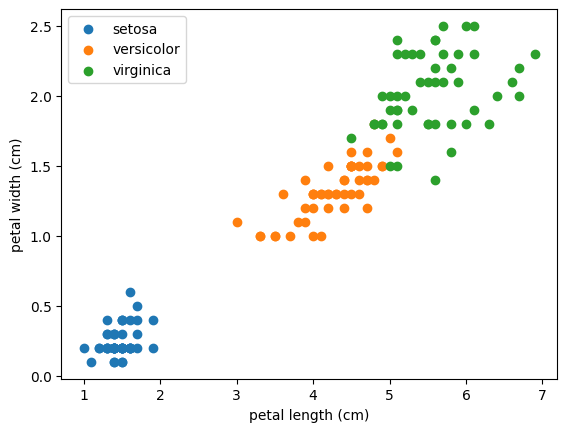

In [ ]:
## visualize the data

plt.scatter(iris['data'][iris.target==0,2],iris['data'][iris.target==0,3], label='setosa')
plt.scatter(iris['data'][iris.target==1,2],iris['data'][iris.target==1,3], label='versicolor')
plt.scatter(iris['data'][iris.target==2,2],iris['data'][iris.target==2,3], label='virginica')
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend()
plt.show()

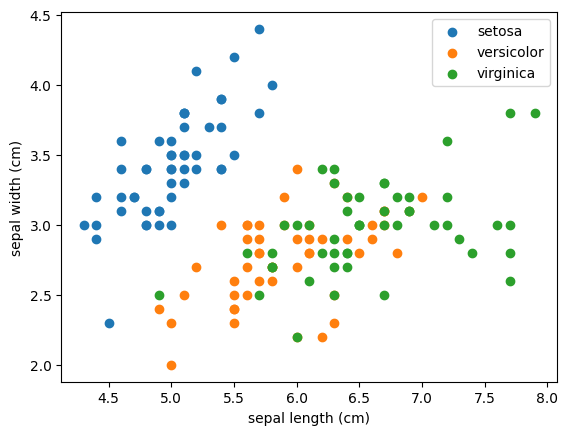

In [ ]:
plt.scatter(iris['data'][iris.target==0,0],iris['data'][iris.target==0,1], label='setosa')
plt.scatter(iris['data'][iris.target==1,0],iris['data'][iris.target==1,1], label='versicolor')
plt.scatter(iris['data'][iris.target==2,0],iris['data'][iris.target==2,1], label='virginica')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.show()

In [ ]:
## fit a decision tree model

X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

**Reference**
* `graphviz`: https://graphviz.org/about/
    * Python library installation: `pip install graphviz`
    * Software Installation (if you are interested): https://graphviz.org/download/

In [ ]:
%%sh

pip install graphviz
# you might need `brew install graphviz` to make the following visualization available

In [ ]:
## visualize the tree

from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file='../pics/iris_tree.dot',
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

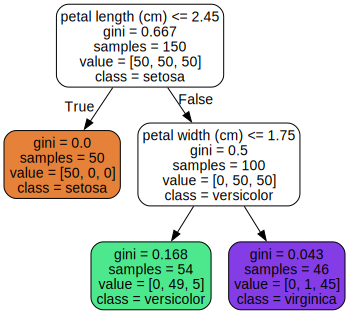

In [ ]:
Source.from_file('../pics/iris_tree.dot')

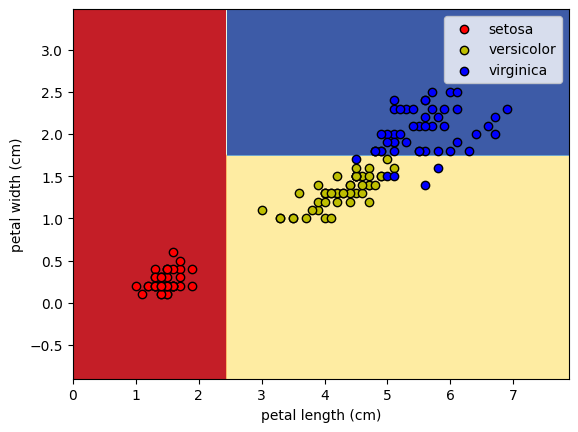

In [ ]:
## visualize the decision boundaries

## generate the grid points
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
plot_step = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

## plot the decision boundary
Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

## plot the raw data
plt.scatter(iris['data'][iris.target==0,2],iris['data'][iris.target==0,3], label='setosa', c='r', edgecolor='black')
plt.scatter(iris['data'][iris.target==1,2],iris['data'][iris.target==1,3], label='versicolor', c='y', edgecolor='black')
plt.scatter(iris['data'][iris.target==2,2],iris['data'][iris.target==2,3], label='virginica',c='b', edgecolor='black')
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend()
plt.show()

## Evaluate the model

In [ ]:
## evaluate the model
y_pred = tree_clf.predict(X)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y, y_pred, labels=[0,1,2])
cnf_matrix

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  5, 45]])

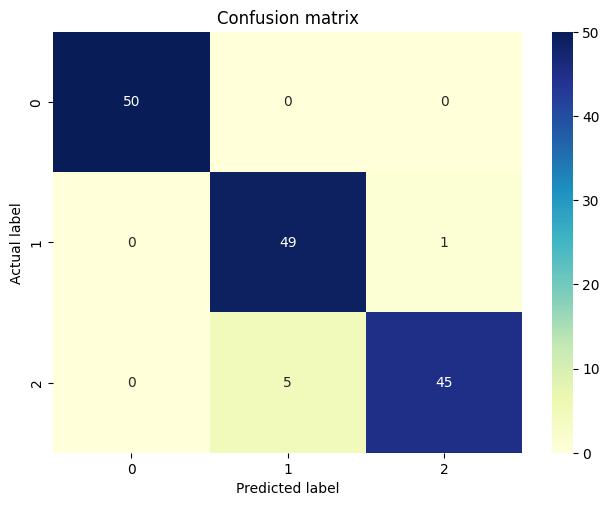

In [ ]:
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Make predictions

In [ ]:
X.shape

(150, 2)

In [ ]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [ ]:
x = tree_clf.predict_proba([[5, 1.5]])
x.shape

(1, 3)

In [ ]:
tree_clf.predict([[5, 1.5]])

array([1])

## Regularization

We are going to use the `moons` dataset: this is a toy dataset for binary classification in which the data points are shaped as two interleaving half circles
* Reference: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

In [ ]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

In [ ]:
Xm.shape

(100, 2)

In [ ]:
ym.shape

(100,)

In [ ]:
Xm[:3]

array([[ 0.20706864,  0.98150398],
       [ 1.16289446,  0.01844799],
       [ 0.1426683 , -0.1109168 ]])

In [ ]:
ym[:3]

array([0, 1, 1])

In [ ]:
set(ym)

{0, 1}

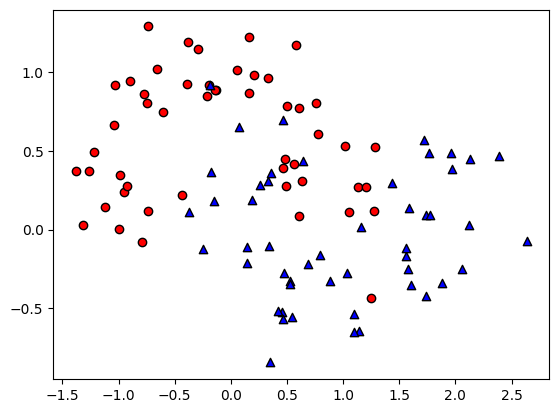

In [ ]:
plt.scatter(Xm[ym==0,0],Xm[ym==0,1],c='r',marker='o',edgecolors='black')
plt.scatter(Xm[ym==1,0],Xm[ym==1,1],c='b',marker='^',edgecolors='black')
plt.show()

Text(0.5, 1.0, 'min_sample_leaf = 4')

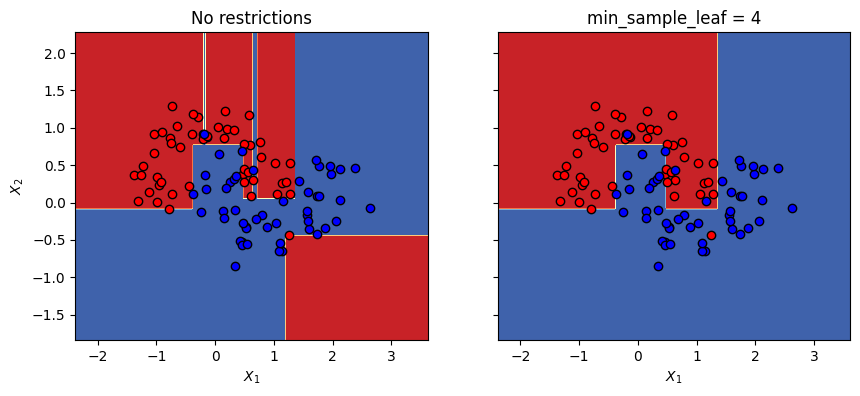

In [ ]:
## Create 2 decision tree models with and without regularization
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

## Create a plotting area
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

## Create datasets for decision boundaries
x_min, x_max = Xm[:, 0].min() - 1, Xm[:, 0].max() + 1
y_min, y_max = Xm[:, 1].min() - 1, Xm[:, 1].max() + 1
plot_step = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

## plot the 1st decision boundary
Z1 = deep_tree_clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z1 = Z1.reshape(xx.shape)
cs = axes[0].contourf(xx, yy, Z1, cmap=plt.cm.RdYlBu)

## plot the 2nd decision boundary
Z2 = deep_tree_clf2.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2.reshape(xx.shape)
cs = axes[1].contourf(xx, yy, Z2, cmap=plt.cm.RdYlBu)

## Add scatter plots of raw data
axes[0].scatter(Xm[ym==0,0],Xm[ym==0,1],c='r', edgecolor='black')
axes[0].scatter(Xm[ym==1,0],Xm[ym==1,1],c='b', edgecolor='black')
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].set_title('No restrictions')

axes[1].scatter(Xm[ym==0,0],Xm[ym==0,1],c='r', edgecolor='black')
axes[1].scatter(Xm[ym==1,0],Xm[ym==1,1],c='b', edgecolor='black')
axes[1].set_xlabel('$X_1$')
axes[1].set_title('min_sample_leaf = 4')



## Apply gridsearch methods to find the best model

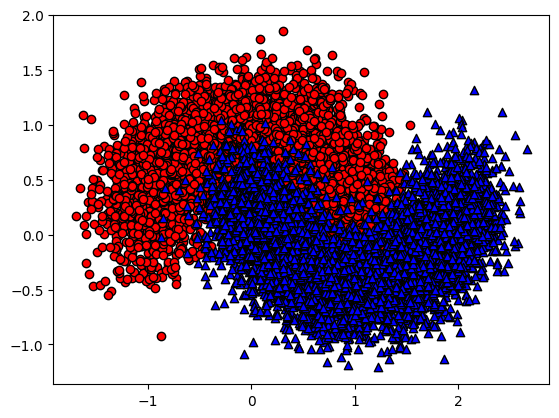

In [ ]:
Xm, ym = make_moons(n_samples=10000, noise=0.25, random_state=53)

plt.scatter(Xm[ym==0,0],Xm[ym==0,1],c='r',marker='o',edgecolors='black')
plt.scatter(Xm[ym==1,0],Xm[ym==1,1],c='b',marker='^',edgecolors='black')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xm, ym, test_size=0.2, random_state=53)

In [ ]:
3 * 98

294

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

params = {'min_samples_split': [2, 3, 4], 'max_leaf_nodes': list(range(2, 100))}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=53), params, verbose=1, cv=3, n_jobs=-1)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits
CPU times: user 529 ms, sys: 237 ms, total: 766 ms
Wall time: 2.96 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=53), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [ ]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=15, random_state=53)

In [ ]:
grid_search_cv.best_estimator_.min_samples_split

2

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
# y_pred.shape
accuracy_score(y_test, y_pred)

0.9355

In [ ]:
sum(y_test==y_pred)/len(y_test)

0.9355

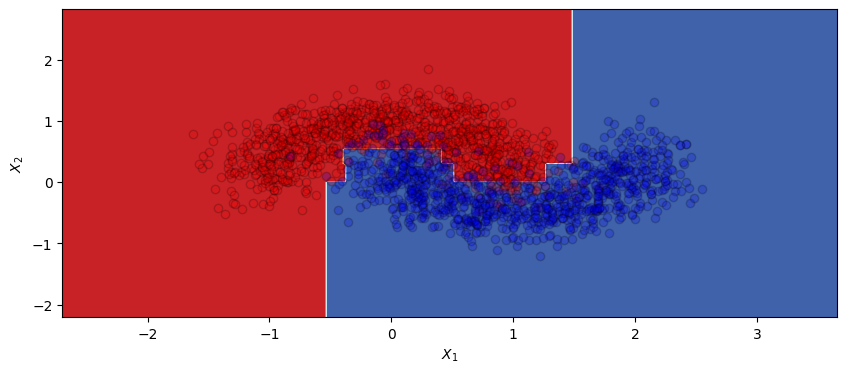

In [ ]:
## Create a plotting area
fig, axes = plt.subplots(figsize=(10, 4))

## Create datasets for decision boundaries
x_min, x_max = Xm[:, 0].min() - 1, Xm[:, 0].max() + 1
y_min, y_max = Xm[:, 1].min() - 1, Xm[:, 1].max() + 1
plot_step = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

## plot the 1st decision boundary
Z = grid_search_cv.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = axes.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

## Add scatter plots of raw data
axes.scatter(X_test[y_test==0,0],X_test[y_test==0,1],c='r', edgecolor='black', alpha=0.2)
axes.scatter(X_test[y_test==1,0],X_test[y_test==1,1],c='b', edgecolor='black', alpha=0.2)
axes.set_xlabel('$X_1$')
axes.set_ylabel('$X_2$')

plt.show()


## Instability of Decision Tree Model

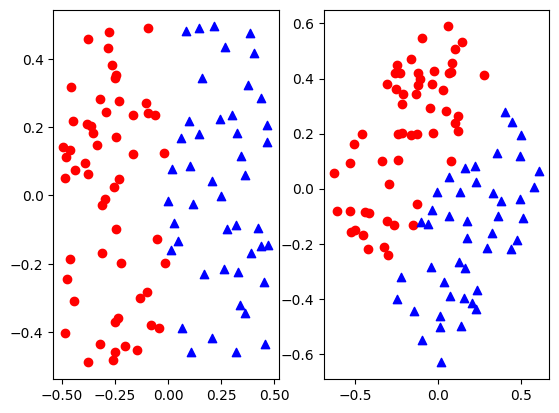

In [ ]:
## Create a sample data
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5 # samples from uniform distribution over [-0.5,0.5]
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

## Rotate the data 45 degrees clockwise
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

## Add scatter plots of raw data
plt.subplot(1,2,1)
plt.scatter(Xs[ys==0,0],Xs[ys==0,1],c='r')
plt.scatter(Xs[ys==2,0],Xs[ys==2,1],c='b',marker='^')

plt.subplot(1,2,2)
plt.scatter(Xsr[ys==0,0],Xsr[ys==0,1],c='r')
plt.scatter(Xsr[ys==2,0],Xsr[ys==2,1],c='b',marker='^')
plt.show()

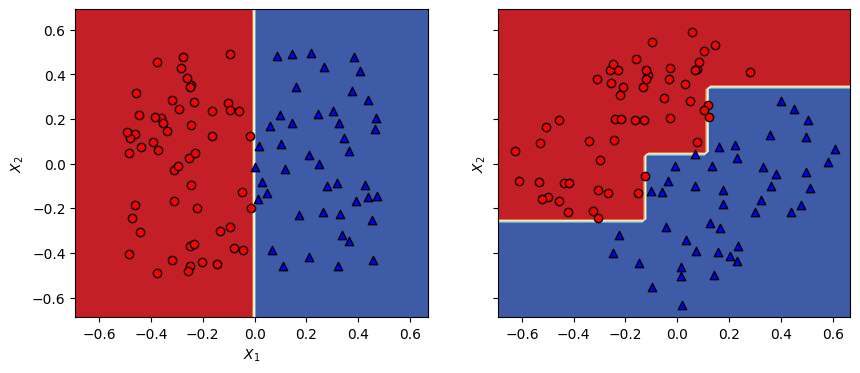

In [ ]:
# create decision tree models to fit on the 2 datasets
tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

## Create a plotting area
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

## Create datasets for decision boundaries
x_min, x_max = Xs[:, 0].min() - 0.2, Xs[:, 0].max() + 0.2
y_min, y_max = Xs[:, 1].min() - 0.2, Xs[:, 1].max() + 0.2
plot_step = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

## plot the 1st decision boundary
Z1 = tree_clf_s.predict(np.c_[xx.ravel(), yy.ravel()])
Z1 = Z1.reshape(xx.shape)
cs = axes[0].contourf(xx, yy, Z1, cmap=plt.cm.RdYlBu)

## plot the 2nd decision boundary
Z2 = tree_clf_sr.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2.reshape(xx.shape)
cs = axes[1].contourf(xx, yy, Z2, cmap=plt.cm.RdYlBu)

## Add scatter plots of raw data
axes[0].scatter(Xs[ys==0,0],Xs[ys==0,1],c='r', edgecolor='black')
axes[0].scatter(Xs[ys==2,0],Xs[ys==2,1],c='b', edgecolor='black', marker='^')
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')

axes[1].scatter(Xsr[ys==0,0],Xsr[ys==0,1],c='r', edgecolor='black')
axes[1].scatter(Xsr[ys==2,0],Xsr[ys==2,1],c='b', edgecolor='black', marker='^')
axes[1].set_ylabel('$X_2$')

plt.show()


## Regression Tree

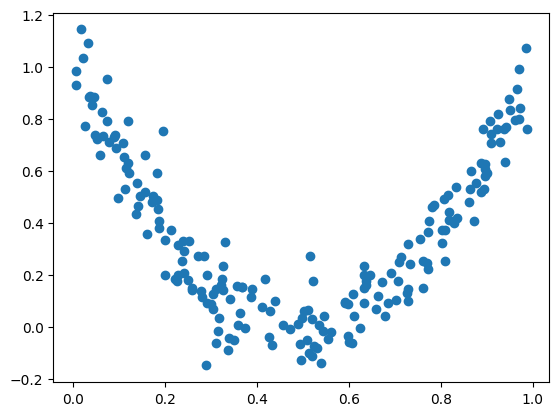

In [ ]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

plt.scatter(X,y)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

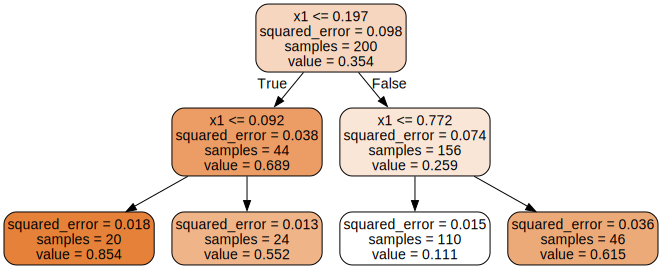

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg1.fit(X, y)

export_graphviz(
        tree_reg1,
        out_file='regression_tree.dot',
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file('regression_tree.dot')

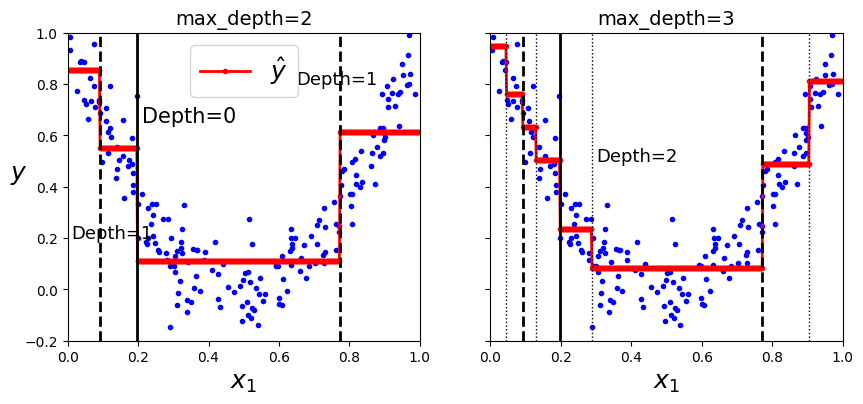

In [ ]:
from sklearn.tree import DecisionTreeRegressor

## train 2 regression tree models
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

## create module to generate true vs. predicted comparison plot
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

## create subplots
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)
plt.show()

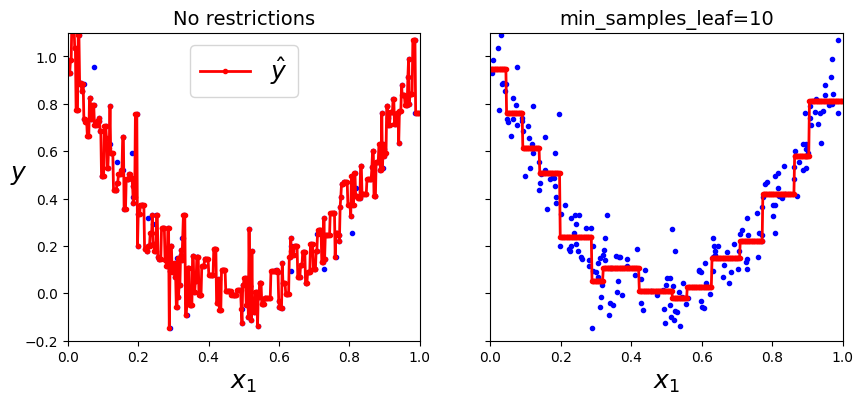

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

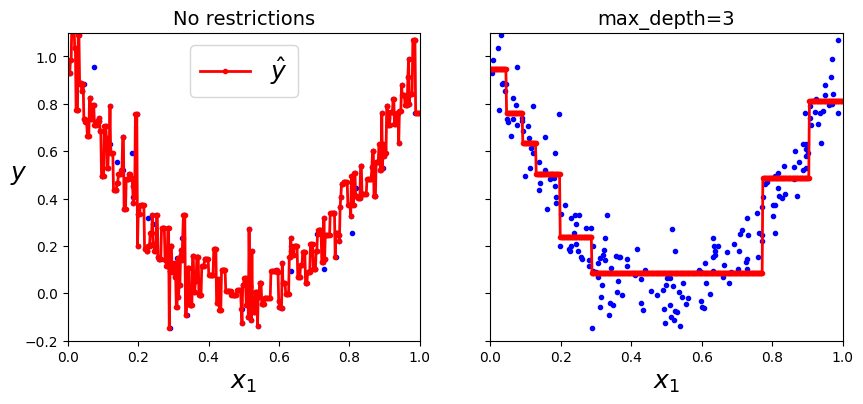

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("max_depth={}".format(tree_reg2.max_depth), fontsize=14)

plt.show()